# XGBoost (iris) - Classification
[ch5-advanced-xgboost-unveiled.ipynb](https://github.com/kyopark2014/ML-Algorithms/blob/main/xgboost/src/ch5-advanced-xgboost-unveiled.ipynb)

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
import xgboost as xgb
xgb.set_config(verbosity=0)

In [5]:
from sklearn import datasets
iris = datasets.load_iris()

In [6]:
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                  columns=iris['feature_names'] + ['target'])

In [7]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


### Shuffle

In [8]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=2)

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
6,4.6,3.4,1.4,0.3,0.0
3,4.6,3.1,1.5,0.2,0.0
113,5.7,2.5,5.0,2.0,2.0
12,4.8,3.0,1.4,0.1,0.0
24,4.8,3.4,1.9,0.2,0.0


In [9]:
df['target'].value_counts()

1.0    50
2.0    50
0.0    50
Name: target, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 6 to 15
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 7.0 KB


In [11]:
df.isna().sum().sum()

0

## Define Feature and Target

In [12]:
X = iris['data']
y = iris['target']

## Classification Model Selection

In [37]:
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kfold = StratifiedKFold(n_splits=5)

def cross_validation(model):
    start = time.time()
    
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold)
    # scores = cross_val_score(model, X, y, scoring='recall', cv=kfold)
    
    print('Cross Validation:')
    print('Elased time: %0.2fs' % (time.time()-start))
    print('Accuracy:', np.round(scores, 2))
    print('Avg. Accuracy: %0.2f' % (scores.mean()))

In [38]:
cross_validation(XGBClassifier(booster='gbtree'))  # default

Cross Validation:
Elased time: 1.81s
Accuracy: [0.97 0.97 0.93 0.93 1.  ]
Avg. Accuracy: 0.96


In [39]:
cross_validation(XGBClassifier(booster='gblinear'))

Cross Validation:
Elased time: 1.92s
Accuracy: [1.   1.   0.93 0.9  1.  ]
Avg. Accuracy: 0.97


In [40]:
cross_validation(XGBClassifier(booster='dart', one_drop=1))

Cross Validation:
Elased time: 3.99s
Accuracy: [0.97 0.97 0.93 0.93 1.  ]
Avg. Accuracy: 0.96


In [41]:
from sklearn.ensemble import RandomForestClassifier

cross_validation(RandomForestClassifier())

Cross Validation:
Elased time: 0.59s
Accuracy: [0.97 0.97 0.93 0.97 1.  ]
Avg. Accuracy: 0.97


## HPO

### Default

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

# define model
model = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)

# default model accuacry 
def getAccuracy(model):
    start = time.time()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    default_score = accuracy_score(y_pred, y_test)

    print('Elapsed time: %0.2fs' % (time.time()-start))    
    print('default score: %0.2f' % (default_score))

getAccuracy(model)

Elapsed time: 0.36s
default score: 0.97


## HPO: Randomized Search

In [21]:
from sklearn.model_selection import RandomizedSearchCV

def randomized_search(params, runs=20): 
    #xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
    #                    random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    xgb = XGBClassifier(booster='gblinear', objective='multi:softprob', 
                        random_state=2, verbosity=0, use_label_encoder=False, n_jobs=-1)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    rand_clf = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=runs, n_jobs=-1, random_state=2, scoring='accuracy')
    
    rand_clf.fit(X_train, y_train)    
    
    best_model = rand_clf.best_estimator_    
    
    best_params = rand_clf.best_params_
    print("best parameter:", best_params)
    
    best_score = rand_clf.best_score_
    print("best score: {:.3f}".format(best_score))
    
    return best_model

In [22]:
import time
start = time.time()

best_model = randomized_search(
    params={
        'n_estimators':[50, 100, 200],
        'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_depth':[1, 2, 3, 5, 6, 8],
        'gamma':[0, 0.01, 0.1, 0.5, 1, 2],
        'min_child_weight':[1, 2, 3, 4, 5],
        'subsample':[0.5, 0.7, 0.8, 0.9, 1],
        'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1],  
        }, 
    runs=20)

print('\nElased time: %0.2fs' % (time.time()-start))

best parameter: {'subsample': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.4, 'gamma': 0.5, 'colsample_bytree': 0.7}
best score: 0.964

Elased time: 954.15s


In [23]:
best_model.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gblinear',
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.7,
 'enable_categorical': False,
 'gamma': 0.5,
 'gpu_id': -1,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.4,
 'max_delta_step': None,
 'max_depth': 8,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 2,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None,
 'validate_parameters': 1,
 'verbosity': 0}

## Evaluation

In [63]:
model = best_model

def model_estimation(model):    
    y_pred = model.predict(X_test)

    from sklearn.metrics import confusion_matrix
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

    from sklearn.metrics import classification_report
    print('\nClassification Report:')
    print(classification_report(y_true=y_test, y_pred = y_pred))

    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('Accuracy Score: %0.2f' % (accuracy_score(y_test,y_pred)))
    print('Precision Score: %0.2f' % (precision_score(y_test,y_pred, average='weighted')))
    print('Recall Score: %0.2f' % (recall_score(y_test,y_pred, average='weighted')))
    print('F1 Score: %0.2f' % (f1_score(y_test,y_pred, average='weighted')))

cross_validation(model)   
model_estimation(model)    

Cross Validation:
Elased time: 4.11s
Accuracy: [1.   1.   0.93 0.9  1.  ]
Avg. Accuracy: 0.97

Confusion Matrix:
[[16  0  0]
 [ 0 10  1]
 [ 0  0 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.91      0.95        11
           2       0.92      1.00      0.96        11

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

Accuracy Score: 0.97
Precision Score: 0.98
Recall Score: 0.97
F1 Score: 0.97


## Feature Importances

Feature Importances:
[[-0.05033117 -0.01120483  0.0149501 ]
 [-0.25571787 -0.03104382  0.06232758]
 [ 0.27688798  0.02734228 -0.04761842]
 [ 1.0885355   0.1693486  -0.2434761 ]]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

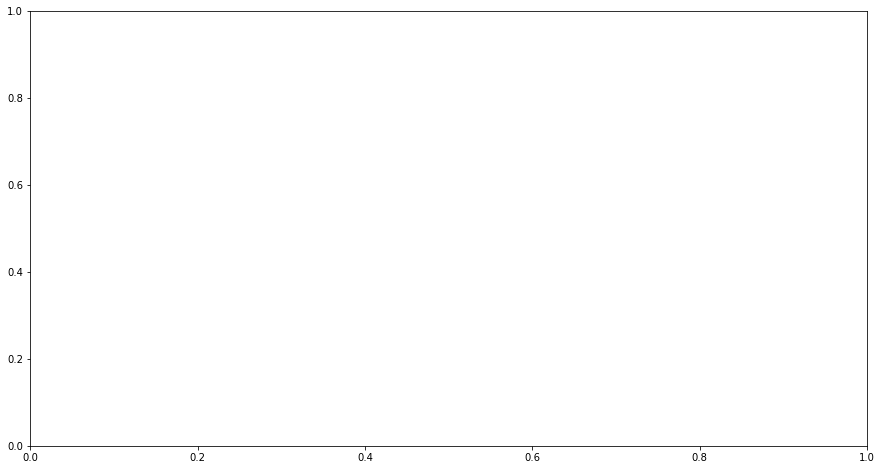

In [65]:
print('Feature Importances:')
print(model.feature_importances_)

import xgboost as xgb

feature_data = xgb.DMatrix(X_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='weight')

!pip install graphviz

xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()